In [1]:
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.losses import MeanAbsolutePercentageError as MAPE
from random import choice,random
import tensorflow as tf
from pprint import pformat,pprint
import keras
import pickle
from keras import layers, models, regularizers, backend, utils
import keras.backend.tensorflow_backend as tfback
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from IPython.core.display import display, HTML

#widen the container width if you want
#display(HTML("<style>.container { width:90% !important; }</style>"))

K = keras.backend
mape = MAPE()
%matplotlib inline

Using TensorFlow backend.


Check if the nvidia-docker container supplied GPU and the tf is using it:

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Set up an options class. The `OPTIONS` dictionary will specify all the possibile configurations of neural networks that the genetic search algorithm can find. The `option` class will initialize as a random object, and you can create a similar `option` to `option1` by calling `option1.get_sim()`.

In [3]:
TEST_RATIO = 0.2
REPEAT = 1

OPTIONS = {"first_lay" : [7,8,9,10],    #log_2 of the amount of neurons on first layer
           "second_lay":[7,8,9,10,11],  #log_2 of the amount of neurons on second layer
           "third_lay" : [7,8,9,10],    #log_2 of the amount of neurons on third layer
           "drop_amt":[0,0.05,0.1,0.15,0.2], #drop probability
           "act": ["sigmoid","relu"], #different activations for network
           "hyper":[0,0.003,0.01,0.03,0.1], #custom loss hyperparameter
           "batch":[128,256,500,1000,2000,8000,20000] #batch size for training network
          }

class option(object):
    def __init__(self):
        self.first_lay = 2**(choice(OPTIONS["first_lay"]))
        self.second_lay = 2**(choice(OPTIONS["second_lay"]))
        self.third_lay = 2**(choice(OPTIONS["third_lay"]))
        self.drop_amt = choice(OPTIONS["drop_amt"])
        self.act =  choice(OPTIONS["act"])
        self.hyper = choice(OPTIONS["hyper"])
        self.batch = choice(OPTIONS["batch"])
    def __str__(self):
        return pformat(self.__dict__)
    def get_sim(self,verbose=False):
        x = option()
        x.__dict__ = dict(self.__dict__)
        pick = choice(list(x.__dict__.keys()))        
        new_val = choice(OPTIONS[pick])
        if verbose:
            print(f"Changed entry {pick} to {new_val}")
        x.__dict__[pick]= new_val
        if "lay" in pick:
            x.__dict__[pick] = 2**x.__dict__[pick]
        return x

Read in the Sydney Data.

In [4]:
files = ["/notebooks/WECs_DataSet/Sydney_Data.csv"]
csvfile = open(files[0])
reader = csv.reader(csvfile, delimiter = ',')
rows = [[float(v) for v in row] for row in reader]
rows = np.asarray(rows, dtype='float32')

This splits the data up into inputs and outputs, and normalizes both. The `REPEAT` option would create more data by switching WEC entries(i.e. same data but select a permutation of WEC coordinates) but for some reason, this random switching of WEC labels really degraded the accuracy.

In [5]:
xs = rows[:,0:32]
ys = rows[:,32:49]
ys = ys / np.max(ys)
xs = xs / np.max(xs)
xs_train, xs_test, ys_train, ys_test = train_test_split(xs,ys,test_size = TEST_RATIO)

if REPEAT>1:#randomize indices of data...didnt help so much
    xs_train = np.reshape(xs_train,(57600,16,2))
    final_train = np.zeros((0,16,2))
    for _ in range(REPEAT):
        hold = np.take(xs_train,np.random.permutation(16),axis=1)
        final_train = np.concatenate([final_train,hold])
    ys_train = np.tile(ys_train.transpose(),REPEAT).transpose()
    xs_train = np.reshape(final_train,(57600*REPEAT,32))
print(xs_train.shape,ys_train.shape)

(57600, 32) (57600, 17)


Given an `option` object, this will create and train a model according to those specifications. Training is done on training data.

In [6]:
def train_model(opt,patience=100,verbose=0):
    def custom_loss(y_true,y_pred):
      return K.mean(K.square(y_pred - y_true), axis=-1) + opt.hyper * K.mean(K.square(K.sum(y_pred[:,0:16], axis=1) - y_pred[:,16]), axis=-1)

    model = models.Sequential()
    model.add(layers.Dense(opt.first_lay, input_dim=32, activation = opt.act))
    model.add(layers.Dropout(opt.drop_amt))
    model.add(layers.Dense(opt.second_lay, activation = opt.act))
    model.add(layers.Dense(opt.third_lay, activation = opt.act))
    model.add(layers.Dense(17, activation = 'linear'))
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience)

    model.compile(keras.optimizers.Adam(learning_rate=0.0003),custom_loss,
                  metrics=['mean_absolute_percentage_error'])
    if verbose!=0:
        model.summary()
    loss_hist = model.fit(xs_train, ys_train, epochs = 30000, shuffle=True,verbose=verbose,
                             validation_data = (xs_test, ys_test), batch_size=opt.batch, callbacks=[callback])
    return model   

Given a model, this function gets the MAPE(Mean Absolute Percentage Error) of the model using test data.

In [7]:
def get_error(model):
    ys_predictions = model.predict(xs_test)
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    error = mape(ys_predictions, ys_test).numpy()
    return error

This will test an `option` object. `option` objects specify structure of neural network to be tested.

In [8]:
def test_options(opt,return_mod = False,patience=100,verbose=0):
    model = train_model(opt,patience=patience,verbose=verbose)
    error = get_error(model)
    if return_mod:
        return error,model
    return error

The following function is a simple genetic algorithm that will search for optimal neural network structures. It will pick possible neural networks based on the `OPTIONS` dictionary.

In [9]:
def genetic_search(patience,verbose):
    with open("list.pickle","rb") as  f:
        lst = pickle.load(f)

    #very simple genetic algorithm
    new_opt = option()
    if random()<0.2:
        print("picking fresh option:")
        print(f"FRESH NEW OPTION:{new_opt}")
    else:
        old_opt,score = choice(lst[:10])
        new_opt = old_opt.get_sim(verbose=True) 
        
        print(f"Making from old option {old_opt} with score {score} a new option {new_opt}")

    score,model = test_options(new_opt,return_mod = True, patience = patience, verbose = verbose)
    lst.append((new_opt,score))
    print(lst[-1][1])
    print()
    lst = sorted(lst,key = lambda x: x[1])
    if score == lst[0][1]:
        print("\n"*5+"NEW BEST!!!\n"*3+"Now saving model....\n"*5)
        model.save("model.h5")
    print(lst[0][1],lst[0][0])
    print([x[1] for x in lst])
    with open("list.pickle","wb") as f:
        pickle.dump(lst,f)

#genetic_search(50,0)

Displays all of the options that I have tested.

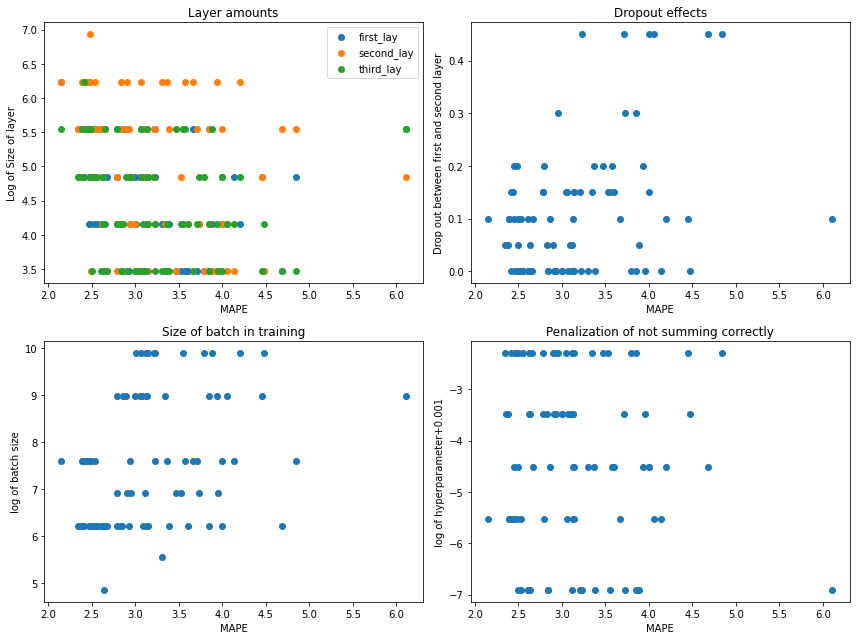

In [10]:
def display_pickled_results():
    with open("list.pickle","rb") as  f:
        lst = pickle.load(f)[1:]
    scores = [x for _,x in lst]
    d = dict()
    for key in OPTIONS.keys():
        d[key]=[x.__dict__[key] for x,_ in lst]
    
    plt.rcParams['figure.figsize'] = [12,9]
    plt.subplot(2,2,1)
    for x in d.keys():
        if "lay" in x:
            plt.scatter(scores,np.log(d[x]), label=x)
    plt.legend()
    plt.title("Layer amounts")
    plt.ylabel("Log of Size of layer")
    plt.xlabel("MAPE")

    plt.subplot(2,2,2)
    plt.scatter(scores,d["drop_amt"])
    plt.title("Dropout effects")
    plt.ylabel("Drop out between first and second layer")
    plt.xlabel("MAPE")
    
    plt.subplot(2,2,3)    
    plt.title("Size of batch in training")
    plt.ylabel("log of batch size")
    plt.xlabel("MAPE")
    plt.scatter(scores,np.log(d["batch"]))
    
    plt.subplot(2,2,4)
    plt.title("Penalization of not summing correctly")
    plt.ylabel("log of hyperparameter+0.001")
    plt.xlabel("MAPE")
    plt.scatter(scores,np.log(np.array(d["hyper"])+0.001))
    plt.tight_layout() 
    plt.show()
    
    
display_pickled_results()

Code to reset the pickle object...be careful.

In [11]:

#if input("Do you want to reset the pickle object?")=="yes":
#    with open("list.pickle","wb") as f:
#        pickle.dump([],f) 


Loads the pickle object, selects the best model that I have trained, then plots its error vs linear regression error.

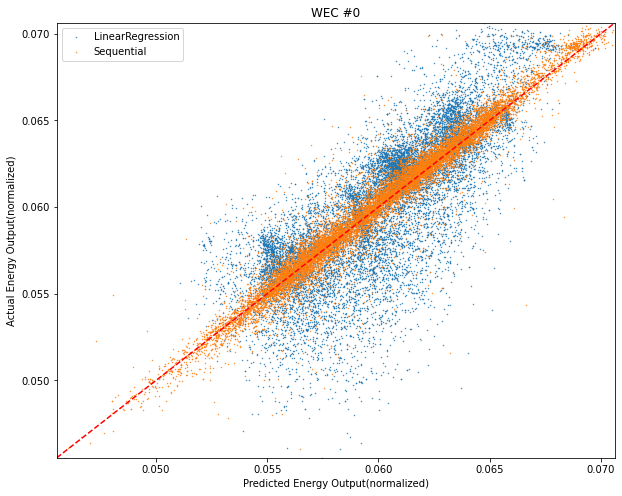

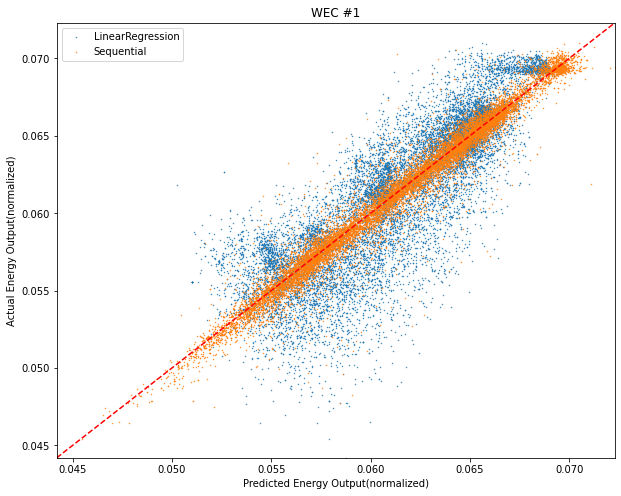

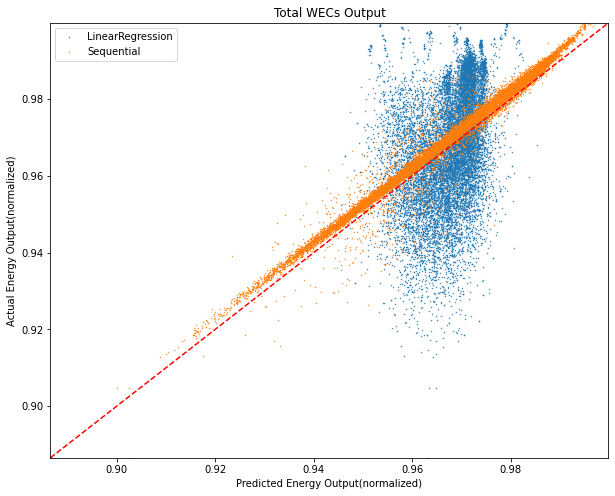

In [12]:
with open("list.pickle","rb") as  f:
        lst = pickle.load(f)
best_opt = lst[0][0]

def custom_loss(y_true,y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1) + best_opt.hyper * K.mean(K.square(K.sum(y_pred[:,0:16], axis=1) - y_pred[:,16]), axis=-1)

sequential_model = models.load_model('model.h5',custom_objects={'custom_loss': custom_loss})


def plot_errors(models,ind=-1):
    maxx,minn = np.max(ys_test[:,ind]),np.min(ys_test[:,ind])
    for model in models:
        name = str(model.__class__).split(".")[-1][:-2]
        ys_predictions = model.predict(xs_test)
        plt.scatter(ys_predictions[:,ind], ys_test[:,ind], alpha = 1, s = 0.19,label=name)
        maxx = max(np.max(ys_predictions[:,ind]),maxx)
        minn = min(np.min(ys_predictions[:,ind]),minn)
    plt.xlabel("Predicted Energy Output(normalized)")
    plt.ylabel("Actual Energy Output(normalized)")
    plt.legend()
    plt.title(f"WEC #{ind}" if ind>=0 else "Total WECs Output")
    t = [minn,maxx]
    plt.axis(t+t)
    plt.plot(t,t,'r--')
    plt.show()

linear_model = LinearRegression().fit(xs_train,ys_train)
myModels = [linear_model,sequential_model]
plt.rcParams['figure.figsize'] = [10,8]
plot_errors(myModels,ind=0)
plot_errors(myModels,ind=1)
plot_errors(myModels,ind=-1)

# WOW 

That last graph is RAZOR sharp. Check the MAPE below.

Compare the MAPE of linear regression vs the sequential network:

In [13]:
print(f"Linear Model MAPE:\t {get_error(linear_model)}")
print(f"Sequential Model MAPE:\t {get_error(sequential_model)}")

Linear Model MAPE:	 3.2085421085357666
Sequential Model MAPE:	 0.9608682990074158


Summary of the best model I have saved

In [14]:
sequential_model.summary()
print(best_opt)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              33792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 17)                17425     
Total params: 4,248,593
Trainable params: 4,248,593
Non-trainable params: 0
_________________________________________________________________
{'act': 'relu',
 'batch': 2000,
 'drop_amt': 0.1,
 'first_lay': 1024,
 'hyper': 0,
 'second_lay': 2048,
 'thir